# Assignment 3 - Credit Default Dataset

Dongbo Zhang

dzhang48@gatech.edu

In [85]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.cluster import KMeans 
from sklearn.mixture import GaussianMixture 
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection as RP
from sklearn.ensemble import RandomForestClassifier

from sklearn.neural_network import MLPClassifier
import time
from sklearn.manifold import TSNE

plt.style.use("ggplot")
# Set constant variables
RANDOM_SEED = 7
RANDOM_SEED_LIST = [7, 1987, 2020, 56, 787, 9876, 4812, 90, 88, 10]
N_FOLDS = 5
TEST_SIZE = 0.3

In [ ]:
!pip install yellowbrick

## Prepare Dataset

Credit Card Clients

Following the same steps used in Assignment 1 to prepare the data set.

In [2]:
# Load Data
cc_data = pd.read_excel('default of credit card clients.xls', header = [1])
cc_data = cc_data.rename(columns={'default payment next month': 'default_flag'})
# Drop NAs from the dataset
cc_data.dropna(inplace=True)


cc_data['SEX'] = cc_data['SEX'].replace(0, np.nan)
cc_data['SEX'] = cc_data['SEX'] - 1

marital_map = {1: 'MARRIED', 2:'SINGLE', 3:'OTHERS'}
cc_data = cc_data.replace({'MARRIAGE': marital_map})

cc_data['EDUCATION'] = cc_data['EDUCATION'].replace(0, np.nan)
cc_data['MARRIAGE'] = cc_data['MARRIAGE'].replace(0, 'NA')

# Assign fields to X (features) and y (dependent variable).
X = cc_data.iloc[:, 1:-1]
y = cc_data['default_flag'].values

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED, 
                                                    test_size=TEST_SIZE)

# One-hot Encoding
X_train = pd.get_dummies(X_train, columns=['MARRIAGE'])
X_test = pd.get_dummies(X_test, columns=['MARRIAGE'])

continuous_features = ['LIMIT_BAL', 'EDUCATION', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
continuous_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy='mean'))])
preprocessing = ColumnTransformer(transformers=[('continuous', continuous_transformer, continuous_features)])
X_train[continuous_features] = preprocessing.fit_transform(X_train)  
X_test[continuous_features] = preprocessing.transform(X_test) 

scaling_transformer = Pipeline(steps = [('scaler', StandardScaler())])
feature_names = X_train.columns
preprocessing = ColumnTransformer(transformers=[('scaler', scaling_transformer, feature_names)])
# Standard Scaling
X_train[feature_names] = preprocessing.fit_transform(X_train)  
X_test[feature_names] = preprocessing.transform(X_test) 


## Part 1: Clustering
### K Means

Run K-Means using different number of clusters, validate the clustering quality, and determine the optimal number of clusters

In [4]:
k_range = range(2,31)

def kmeans_iterate(k_range, X_features):
    res = {'k':[],
           'silhouette':[],
           'fit_time':[],
           'sse':[],
           }
    km_models = {}
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=20)
        start_time = time.process_time()
        kmeans.fit(X_features)
        elapse = time.process_time() - start_time
        
        kmeans_labels = kmeans.predict(X_features)
        silhouette = silhouette_score(X_features, kmeans_labels)

        sse = kmeans.inertia_
        res['k'].append(k)
        res['silhouette'].append(silhouette)
        res['fit_time'].append(elapse)
        res['sse'].append(sse)
        km_models[k] = kmeans
        
    return res, km_models
        
kmeans_exp, km_models = kmeans_iterate(k_range, X_train)

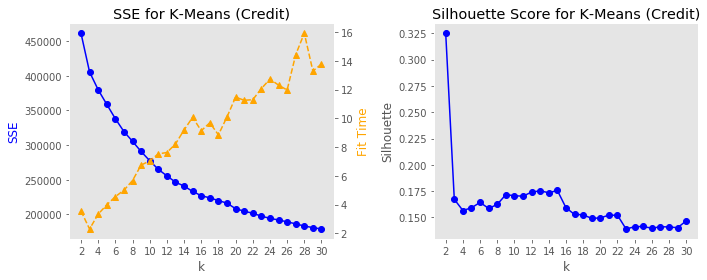

In [5]:
def plot_kmeans_internal_valid(exp_res, title, prefix='', dataset=''):
    """
    Use internal clustering criteria to validate K-means clustering
    with different numbers of clusters
    """
    
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(exp_res['k'], exp_res['sse'], marker='o', color='b')
    ax[0].set_xlabel('k')
    ax[0].set_ylabel('SSE', color='b')
    #ax[0].set_ylim([4000, 16000])
    ax[1].plot(exp_res['k'], exp_res['silhouette'], marker='o', color='b')
    ax[1].set_xlabel('k')
    ax[1].set_ylabel('Silhouette')    
    ax[0].grid(False)
    ax[1].grid(False)
    ax[0].set_title('SSE for {} {}'.format(title, dataset))
    ax[1].set_title('Silhouette Score for {} {}'.format(title, dataset))
    
    
    ax2 = ax[0].twinx()
    ax2.set_ylabel('Fit Time', color='orange')
    ax2.grid(False)
    ax2.plot(exp_res['k'], exp_res['fit_time'], marker='^', linestyle='--', color='orange')
    
    ax[0].set_xticks(range(2, 32, 2))
    ax[1].set_xticks(range(2, 32, 2))

    plt.tight_layout()
    plt.savefig(prefix+'kmeans_internal_val.png', dpi=200)
    plt.show()
    
plot_kmeans_internal_valid(kmeans_exp, 'K-Means', prefix='credit_orig_', dataset='(Credit)')

### Use library YellowBrick to determine the elbow

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


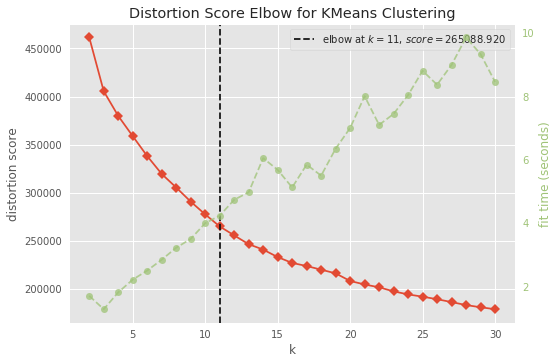

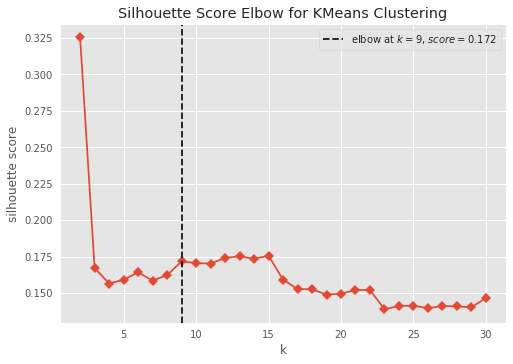

In [6]:
from yellowbrick.cluster import KElbowVisualizer
plt.style.use('ggplot')
model = KMeans(random_state=RANDOM_SEED, n_init=20)
visualizer_sse = KElbowVisualizer(model, k=(2,31), timings=True, colors='bold')
visualizer_sse.fit(X_train)       
visualizer_sse.show()       
visualizer_silhouette = KElbowVisualizer(model, k=(2,31),  metric='silhouette', timings=False)
visualizer_silhouette.fit(X_train)       
visualizer_silhouette.show()

### Use Silhouette plots for analysis

For n_clusters = 2 The average silhouette_score is : 0.3252145731577567
For n_clusters = 9 The average silhouette_score is : 0.17162663878009282
For n_clusters = 15 The average silhouette_score is : 0.17559876633145496


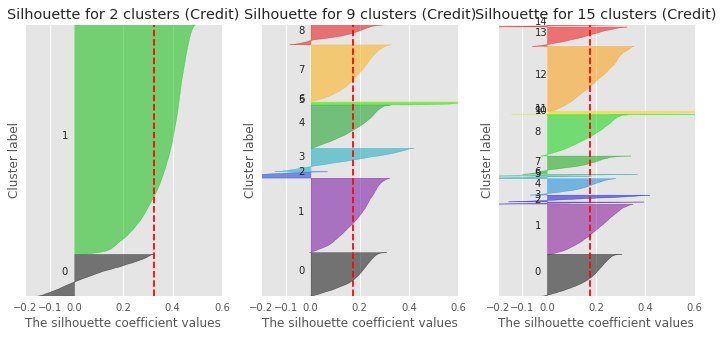

In [7]:
import matplotlib.cm as cm
def plot_silhouette(range_n_clusters, X, model, title='', dataset=''):
    """
    Below code is modified from Scikit Learn page:https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    
    
    """
    X = np.array(X)
    tsne = TSNE(n_components=2, random_state=RANDOM_SEED) # first try without init='pca'
    X_tsne = tsne.fit_transform(X)
    fig, ax = plt.subplots(1, 3, figsize=(12,5))
    for k, n_clusters in enumerate(range_n_clusters):

        ax[k].set_xlim([-0.2, 0.6])
        ax[k].set_ylim([0, len(X) + (n_clusters + 1) * 10])
        if model == 'kmeans':
            clusterer = KMeans(random_state=RANDOM_SEED, n_init=20, n_clusters=n_clusters)
        elif model == 'gmm':
            clusterer = GaussianMixture(n_components=n_clusters,  n_init=20, random_state=RANDOM_SEED, covariance_type='full')
        
        cluster_labels = clusterer.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
        
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax[k].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.5)

            # Label the silhouette plots with their cluster numbers at the middle
            ax[k].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax[k].set_title("Silhouette for {} clusters ({})".format(n_clusters, dataset))
        ax[k].set_xlabel("The silhouette coefficient values")
        ax[k].set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax[k].axvline(x=silhouette_avg, color="red", linestyle="--")

        ax[k].set_yticks([])  
        ax[k].set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6])
    plt.savefig(title+'silhouette_plot.png', dpi=200)
    plt.show()
    
    
plot_silhouette([2, 9, 15], X_train, 'kmeans', title='credit_orig_', dataset='Credit')

Use external evaluation to validate K-means clustering

In [8]:
from sklearn.metrics import homogeneity_score, completeness_score, normalized_mutual_info_score
from sklearn import metrics
    
def plot_eval_external(models, n_clusters_list, X, y):
    res_new = {'k':[],'homo_score':[], 'complete_score':[], 'v_score':[],'adj_rand_index':[],
          'adj_mutual_info':[],}
    for k in n_clusters_list:
        res_new['k'].append(k)
        optimal_kmeans = models[k]
        kmeans_labels_pred = optimal_kmeans.predict(X)
        res_new['homo_score'].append(homogeneity_score(y, kmeans_labels_pred))
        res_new['complete_score'].append(completeness_score(y, kmeans_labels_pred))
        res_new['v_score'].append(normalized_mutual_info_score(y, kmeans_labels_pred))
        res_new['adj_rand_index'].append(metrics.adjusted_rand_score(y, kmeans_labels_pred))
        res_new['adj_mutual_info'].append(metrics.adjusted_mutual_info_score(y, kmeans_labels_pred))
    return pd.DataFrame(res_new)
kmeans_external = plot_eval_external(km_models, [2, 3, 4, 9, 11], X_train, y_train)
            
kmeans_external

,k,homo_score,complete_score,v_score,adj_rand_index,adj_mutual_info
0,2,0.000087,0.000108,0.000096,-0.005175,0.000047
1,3,0.014623,0.008028,0.010366,-0.014118,0.010302
2,4,0.011956,0.004817,0.006867,0.004371,0.006790
3,9,0.071131,0.020695,0.032062,0.019755,0.031904
4,11,0.070584,0.019530,0.030594,0.016728,0.030401


### Choose the optimal number of clusters (k) = 9

Plot K-Means Clusters

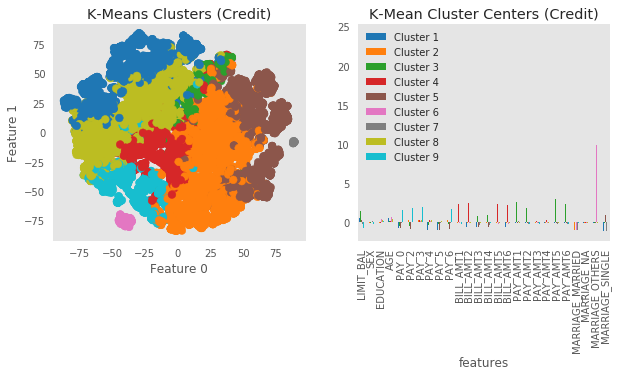

In [9]:
optimal_num_clusters = 9

def optimal_kmeans_analysis(X, optimal_num_clusters, save_fig=False, title='', dataset=''):
    tsne = TSNE(n_components=2, random_state=RANDOM_SEED) # first try without init='pca'
    X_tsne = tsne.fit_transform(X)
          
    optimal_kmeans = KMeans(random_state=RANDOM_SEED, n_init=20, n_clusters=optimal_num_clusters)
    start_time = time.process_time()
    optimal_kmeans.fit(X)
    elapse = time.process_time() - start_time
    y_pred = optimal_kmeans.predict(X)


    cluster_centers = {'features': X.columns}
    for i in range(1, optimal_num_clusters+1):
        cluster_centers['Cluster '+ str(i)] = optimal_kmeans.cluster_centers_[i-1]
    optimal_kmeans_centers = pd.DataFrame(cluster_centers)
    optimal_kmeans_centers.set_index('features', inplace=True)


    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].scatter(X_tsne[:,0], X_tsne[:,1], c=y_pred, s=60, cmap='tab10')
    ax[0].set_xlabel("Feature 0")
    ax[0].set_ylabel("Feature 1")
    ax[0].set_title('K-Means Clusters ({})'.format(dataset))
    optimal_kmeans_centers.plot(kind='bar', ax=ax[1], cmap='tab10')
    #ax[1].set_xticklabels(optimal_kmeans_centers.index, rotation=0)
    ax[1].set_title('K-Mean Cluster Centers ({})'.format(dataset))
    ax[0].grid(False)
    ax[1].grid(False)
    if save_fig:
        plt.savefig(title+'optimal_kmeans.png', dpi=200, bbox_inches = 'tight')
    plt.show()
    return optimal_kmeans, optimal_kmeans_centers, elapse
optimal_kmeans_orig, optimal_kmeans_orig_centers, optimal_kmeans_orig_fit_time = optimal_kmeans_analysis(X_train, optimal_num_clusters, save_fig=True, title='credit_orig_', dataset='Credit')

### Expectation Maximization (EM)

In [58]:
def em_iterate(k_range, X_features, cov_type):
    res = {'k':[], 
           'silhouette':[],
           'aic':[],
           'bic':[],
           'fit_time':[]}
    em_models = {}
    for k in k_range:
        print (k)
        em = GaussianMixture(n_components=k,  n_init=20, random_state=RANDOM_SEED, covariance_type=cov_type)
        start_time = time.process_time()
        em.fit(X_features)
        elapse = time.process_time() - start_time
        em_labels = em.predict(X_features)
        em_models[k] = em
        silhouette = silhouette_score(X_features, em_labels)
        
        aic = em.aic(X_features)
        bic = em.bic(X_features)
        res['k'].append(k)
        res['silhouette'].append(silhouette)
        res['aic'].append(aic)
        res['bic'].append(bic)
        res['fit_time'].append(elapse)
        
    return res, em_models
        
em_exp_full, em_models_full = em_iterate(k_range, X_train, 'full')
em_exp_tied, em_models_tied = em_iterate(k_range, X_train, 'tied')
em_exp_diag, em_models_diag = em_iterate(k_range, X_train, 'diag')
em_exp_sphe, em_models_sphe = em_iterate(k_range, X_train, 'spherical')

In [59]:
def plot_em_exp(exp_res, title, save_fig=False,prefix=""):
    colors = ['g','orange','b','r']
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    for i, k in enumerate(list(exp_res.keys())):
        ax[0].plot(exp_res[k]['k'], exp_res[k]['aic'], linestyle = '--', marker='.',  color=colors[i], label='AIC '+k)
        ax[0].plot(exp_res[k]['k'], exp_res[k]['bic'], color=colors[i], marker='.', label='BIC '+k)
        ax[1].plot(exp_res[k]['k'], exp_res[k]['silhouette'], marker='o', color=colors[i], label=k )
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('AIC, BIC')
    
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('Silhouette Score')
    ax[0].grid(False)
    ax[1].grid(False)
    ax[0].set_title('AIC & BIC ({})'.format(title))
    ax[1].set_title('Silhouette Score ({})'.format(title))
    ax[0].legend()
    ax[1].legend()
    ax[0].set_xticks(range(2, 32, 2))
    ax[1].set_xticks(range(2, 32, 2))
    
    #ax2 = ax[1].twinx() 
    #ax2.set_ylabel('Fit Time', color='orange')
    #ax2.plot(exp_res['k'], exp_res['fit_time'], marker='^', linestyle='--', color='orange')
    #ax2.grid(False)

    plt.tight_layout()
    if save_fig:
        plt.savefig(prefix+'em_internal_val.png', dpi=100)
    plt.show()
    
em_exp_all = {'Full':em_exp_full,'Tied':em_exp_tied,'Diag':em_exp_diag, 'Spherical':em_exp_sphe}
plot_em_exp(em_exp_all, 'EM on Credit Data', save_fig=True, prefix='credit_orig_')

"\nprint ('===FULL===') \nplot_em_exp(em_exp_full, 'EM on Credit Data')\nprint ('===TIED===') \nplot_em_exp(em_exp_tied, 'EM on Credit Data')\nprint ('===DIAG===') \nplot_em_exp(em_exp_diag, 'EM on Credit Data')\nprint ('===SPHERICAL===') \nplot_em_exp(em_exp_sphe, 'EM on Credit Data')\n"

### Evaluate EM using the optimal number of clusters (k)

In [ ]:
em_external = plot_eval_external(em_models_full, [2, 4, 5, 6, 9, 11], X_train, y_train)
            
em_external

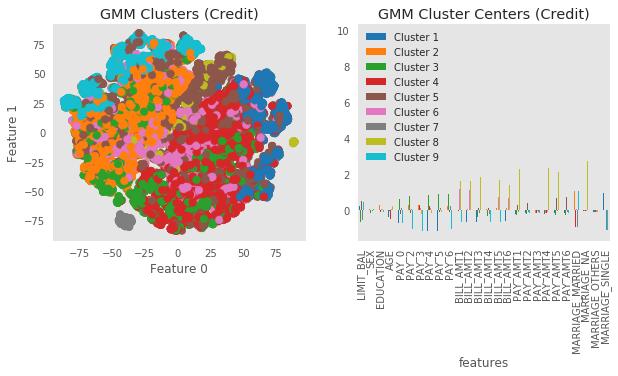

In [98]:
def optimal_gmm_analysis(X, optimal_num_clusters, save_fig=False, title='', dataset=''):
    tsne = TSNE(n_components=2, random_state=RANDOM_SEED) # first try without init='pca'
    X_tsne = tsne.fit_transform(X)
          
    optimal_gmm = GaussianMixture(random_state=RANDOM_SEED,  n_components=optimal_num_clusters)


    start_time = time.process_time()
    optimal_gmm.fit(X)
    elapse = time.process_time() - start_time
    y_pred = optimal_gmm.predict(X)


    cluster_centers = {'features': X.columns}
    for i in range(1, optimal_num_clusters+1):
        cluster_centers['Cluster '+ str(i)] = optimal_gmm.means_[i-1]
    optimal_gmm_centers = pd.DataFrame(cluster_centers)
    optimal_gmm_centers.set_index('features', inplace=True)


    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].scatter(X_tsne[:,0], X_tsne[:,1], c=y_pred, s=60, cmap='tab10')
    ax[0].set_xlabel("Feature 0")
    ax[0].set_ylabel("Feature 1")
    ax[0].set_title('GMM Clusters ({})'.format(dataset))
    optimal_gmm_centers.plot(kind='bar', ax=ax[1], cmap='tab10')
    #ax[1].set_xticklabels(optimal_kmeans_centers.index, rotation=0)
    ax[1].set_title('GMM Cluster Centers ({})'.format(dataset))
    ax[0].grid(False)
    ax[1].grid(False)
    if save_fig:
        plt.savefig(title+'optimal_gmm.png', dpi=100, bbox_inches = 'tight')
    plt.show()
    return optimal_gmm, optimal_gmm_centers, elapse

optimal_num_clusters_gmm = 9
optimal_gmm_orig, optimal_gmm_orig_centers, optimal_gmm_orig_fit_time = optimal_gmm_analysis(X_train, 
                                                                                             optimal_num_clusters_gmm,
                                                                                             
                                                                                                      save_fig=True, title='credit_orig_', dataset='Credit')


## Part 2: Dimension Reduction

### 2.1 Principal Component Analysis (PCA)

PCA tries to find a low-dimensional representation of the features while keeping as much information as possible.

In [10]:
def pca_experiment(n_comp, X_features):
    
    
    pca = PCA(n_components=n_comp,
                  whiten=False, random_state=RANDOM_SEED).fit(X_features)
    X_features_PCA = pd.DataFrame(pca.transform(X_features))

    
    # Explained Variance
    
    explained_var_ratio =  pca.explained_variance_ratio_  
    sum_explained_var_ratio = np.cumsum(explained_var_ratio)
    
    # Reconstruction Error
    reconst_errors, pca_res = [], {}
    for k in range(1,n_comp+1):
        pca = PCA(n_components=k,
                  whiten=False, random_state=RANDOM_SEED).fit(X_features)
        X_features_PCA_ = pd.DataFrame(pca.transform(X_features))
        pca_res[k] = pca
        reconstruct_X_features = pd.DataFrame(pca.inverse_transform(X_features_PCA_))
        reconst_error = mean_squared_error(reconstruct_X_features, X_features)
        reconst_errors.append(reconst_error)
    
    res_metrics = {'n_principal_comp':list(range(1,n_comp+1)), 
           'Variance Explained by Comp': explained_var_ratio,
           'Cumulative Variance Explained':sum_explained_var_ratio,
           'Reconstruction Error': reconst_errors}
    
    return res_metrics, pca_res

X_pca_metrics, X_pca_res = pca_experiment(X_train.shape[1], X_train)
X_pca_metrics_df = pd.DataFrame(X_pca_metrics)


    


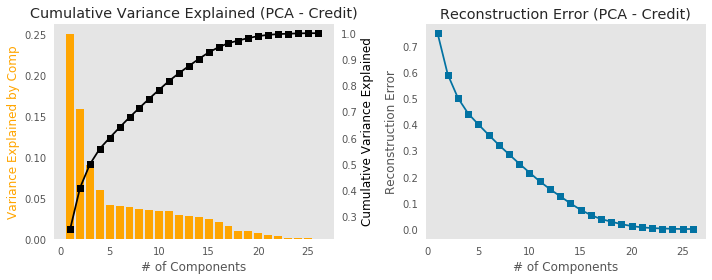

In [11]:
def plot_dim_reduct_exp(exp_res, title, fields=[], colors=['black','b','orange'], pca_col = []):
    if len(fields) > 0:
        fig, ax = plt.subplots(1, len(fields), figsize=(4*len(fields)+2,4))
        if len(fields) == 1:
            ax.plot(exp_res[exp_res.columns[0]], exp_res[fields[0]], marker='.', color=colors[0])
            ax.set_xlabel('# of Components')
            ax.set_ylabel('{}'.format(fields[0]))
            ax.grid(False)
            ax.set_title('{} ({})'.format(fields[0], title))
        else:
            if len(pca_col) > 0:
                ax[0].set_xlabel('# of Components')
                ax[0].set_ylabel('{}'.format(pca_col[0]), color=colors[-1])
                ax[0].grid(False)
                ax2 = ax[0].twinx() 
                
                ax2.set_ylabel('{}'.format(fields[0]),color=colors[0])

                ax2.grid(False)
                ax[0].bar(exp_res[exp_res.columns[0]], exp_res[pca_col[0]], color=colors[-1])
                
                ax2.plot(exp_res[exp_res.columns[0]], exp_res[fields[0]], marker='s', color=colors[0])
                
                ax[0].set_title('{} ({})'.format(fields[0], title))
            plot_range = range(1, len(fields)) if len(pca_col) > 0 else range(len(fields))
            for i in plot_range:
                ax[i].plot(exp_res[exp_res.columns[0]], exp_res[fields[i]], marker='s', color=colors[i])
                ax[i].set_xlabel('# of Components')
                ax[i].set_ylabel('{}'.format(fields[i]))
                ax[i].grid(False)
                ax[i].set_title('{} ({})'.format(fields[i], title))
        plt.tight_layout()
        plt.savefig('{}.png'.format(title), dpi=200)
        
        plt.show()
        
    
plot_dim_reduct_exp(X_pca_metrics_df, 
                    'PCA - Credit', ['Cumulative Variance Explained','Reconstruction Error'],
                    pca_col = ['Variance Explained by Comp'])  

Optimal # of dimension using PCA: 11 (with cumulative variance explained >= 0.8)

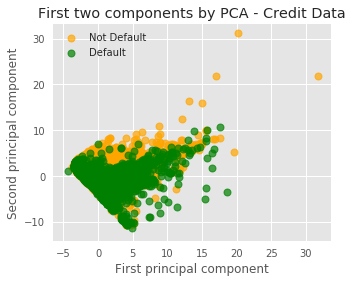

In [13]:
num_comp_PCA = 11
pca = PCA(n_components=num_comp_PCA,
                  whiten=False, random_state=RANDOM_SEED).fit(X_train)

X_train_features_PCA = pd.DataFrame(pca.transform(X_train))
X_test_features_PCA = pd.DataFrame(pca.transform(X_test))


def plot_dr(X_feature, y, title, filename):
    colors=['orange', 'green', 'blue']
    X_feature = np.array(X_feature)
    plt.figure(figsize=(5, 4))

    for color, i, target_name in zip(['orange', 'green'], [0, 1], ['Not Default','Default']):
        plt.scatter(X_feature[y == i, 0], X_feature[y == i, 1], color=color, alpha=.7, lw=1,
                label=target_name)  
    plt.legend()
    plt.title('First two components by {}'.format(title))
    if 'PCA' in title:
        plt.xlabel("First principal component")
        plt.ylabel("Second principal component")
    else:
        plt.xlabel("First component")
        plt.ylabel("Second component")
    plt.savefig(filename+'_visualization.png',dpi=200 ,bbox_inches = 'tight') 

plot_dr(X_train_features_PCA, y_train, 'PCA - Credit Data', 'CREDIT_PCA' ) 

### 2.2 Independent Component Aanalysis

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


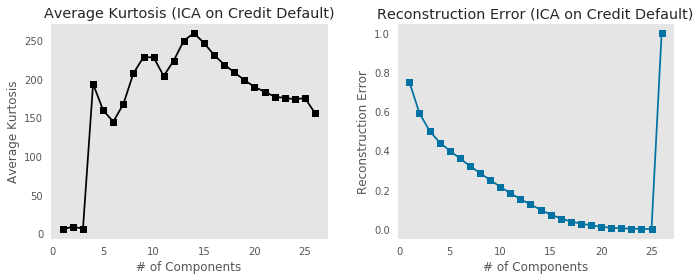

In [14]:
def ica_experiment(n_comp, X_features):
    kurtosis_list, reconst_errors, res_ica = [], [], {}
    for k in range(1, n_comp+1):
        ica = FastICA(n_components=k, max_iter = 1000, random_state=RANDOM_SEED).fit(X_features)
        X_features_ICA = pd.DataFrame(ica.transform(X_features))
        res_ica[k] = ica
        
        # Kurtosis
        mean_kurtosis = X_features_ICA.kurtosis(axis=0).abs().mean()
        kurtosis_list.append(mean_kurtosis)
        
        # Reconstruction Error
    
        reconstruct_X_features = pd.DataFrame(ica.inverse_transform(X_features_ICA))
        
        reconst_error = mean_squared_error(reconstruct_X_features, X_features)
        reconst_errors.append(reconst_error)

    
    res_metrics = {'n_comp':list(range(1,n_comp+1)), 
           'Average Kurtosis':kurtosis_list,
           'Reconstruction Error':reconst_errors}

    return res_metrics, res_ica



    


X_ica_metrics,  X_ica_res= ica_experiment(X_train.shape[1], X_train)
X_ica_metrics_df = pd.DataFrame(X_ica_metrics) 

plot_dim_reduct_exp(X_ica_metrics_df, 'ICA on Credit Default', ['Average Kurtosis','Reconstruction Error'])

Optimal # of dimensions: num_comp = 14

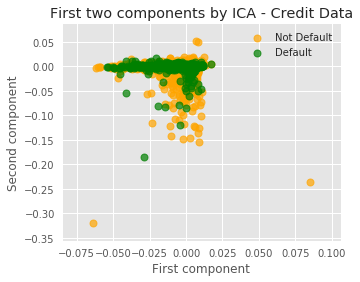

In [15]:
num_comp_ICA = 14
pca = PCA(n_components=num_comp_PCA,
            whiten=False, random_state=RANDOM_SEED).fit(X_train)

ica = FastICA(n_components=num_comp_ICA, max_iter = 1000, random_state=RANDOM_SEED).fit(X_train)

X_train_features_ICA = pd.DataFrame(ica.transform(X_train))
X_test_features_ICA = pd.DataFrame(ica.transform(X_test))

plot_dr(X_train_features_ICA, y_train, 'ICA - Credit Data', 'CREDIT_ICA') 

### 2.3 Random Projection

In [16]:
def rp_experiment(n_comp, X_features):
    res_list, model_list = [], []
    for seed in RANDOM_SEED_LIST:
        reconst_errors, res_rp = [], {}
        for k in range(1, n_comp+1):
            rp = RP(n_components=k,  random_state=seed).fit(X_features)
            X_features_RP = pd.DataFrame(rp.transform(X_features))
            res_rp[k] = rp
        
            # Reconstruction Error
            # The reconstruction of RP is using the same code from the inverse_transform function from ICA
            # https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/decomposition/_fastica.py#L604
            reconstruct_X_features = pd.DataFrame((X_features_RP.dot(np.linalg.pinv(rp.components_.T))))
            reconst_error = mean_squared_error(reconstruct_X_features, X_features)
            reconst_errors.append(reconst_error)
    
        res = {'n_comp':list(range(1,n_comp+1)), 
           'Reconstruction Error':reconst_errors}
        res_list.append(pd.DataFrame(res))
        model_list.append(res_rp)
    
    return res_list, model_list


X_rp_metrics, X_rp_res = rp_experiment(X_train.shape[1], X_train)

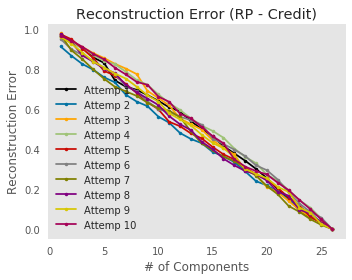

In [17]:
def plot_dim_reduct_exp_RP(exp_res, title, fields=[], colors=['black','b','orange','g', 'r', 
                                                              'gray','olive','purple', 'y','m']):
    if len(fields) > 0:
        fig, ax = plt.subplots(1, len(fields), figsize=(4*len(fields)+1,4))
        for i, res in enumerate(exp_res):
            ax.plot(res[res.columns[0]], res[fields[0]], marker='.', color=colors[i], label='Attemp {}'.format(i+1))
        ax.legend()
        ax.set_xlabel('# of Components')
        ax.set_ylabel('{}'.format(fields[0]))
        ax.grid(False)
        ax.set_title('{} ({})'.format(fields[0], title))

        plt.tight_layout()
        plt.savefig('{}.png'.format(title), dpi=200)
        
        plt.show()
        
plot_dim_reduct_exp_RP(X_rp_metrics, 'RP - Credit', fields=['Reconstruction Error'])

Given that the components by PCA and ICA all result in reconstruction error <= 0.2, we set a threhold of reconstruction error <= 0.2 for RP as well. We use a voting approach to select the # of components in the five runs.

In [18]:
comp_nums={}
for metrics_df in X_rp_metrics:
    comp_num=metrics_df[metrics_df['Reconstruction Error'] <= 0.2]['n_comp'].min()
    if comp_num not in comp_nums:
        comp_nums[comp_num] = 0
    else:
        comp_nums[comp_num] += 1
    
comp_nums

{21: 4, 22: 4}

Select the number of components = 21

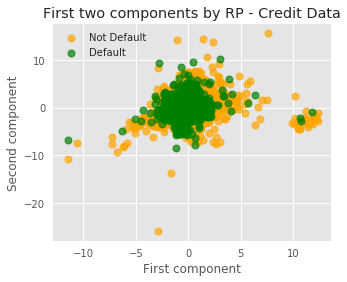

In [19]:
num_comp_RP= 21
rp = RP(n_components=num_comp_RP,  random_state=RANDOM_SEED).fit(X_train)
            
X_train_features_RP = pd.DataFrame(rp.transform(X_train))
X_test_features_RP = pd.DataFrame(rp.transform(X_test))

plot_dr(X_train_features_RP, y_train, 'RP - Credit Data', 'CREDIT_RP') 

### 2.4 Random Forest (RF)

In [ ]:

param_grid = {
 'n_estimators': [200, 500], 
 'min_samples_leaf':[1, 2, 4],
 'min_samples_split': [2, 5, 10],
 }
# 'max_features':['auto','sqrt'], 'min_samples_leaf':[1, 2, 4]
rfc = RandomForestClassifier(random_state=RANDOM_SEED)
# Use function GridSearchCV 
grid = GridSearchCV(estimator=rfc, param_grid=param_grid,  cv=N_FOLDS, scoring = 'roc_auc', verbose=3)
grid.fit(X_train, y_train) 

# Find best model parameters
print ("Best Model Parameters:", grid.best_params_)



Use the Random Forest Classifier with the optimal parameters:  {'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500}

In [21]:
rfc = RandomForestClassifier(n_estimators=500, min_samples_split=10, min_samples_leaf=4, random_state=RANDOM_SEED)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

Calculate Feature Importance

In [22]:
features_importance = pd.DataFrame({'Feature Importance':rfc.feature_importances_, 'Feature':X_train.columns})
features_importance.sort_values('Feature Importance', ascending=False, inplace=True)
features_importance['Cumulative Importance'] = features_importance['Feature Importance'].cumsum()
#features_importance.set_index('Feature', inplace=True)

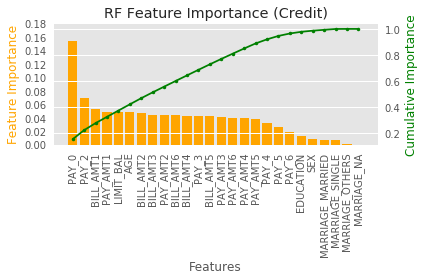

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.bar(features_importance['Feature'], features_importance['Feature Importance'], color='orange')
ax.set_xlabel('Features')
ax.set_ylabel('{}'.format('Feature Importance'), color='orange')
ax.grid(None)
ax.set_xticklabels(features_importance['Feature'], rotation=90)
ax2 = ax.twinx() 
                
ax2.set_ylabel('{}'.format('Cumulative Importance'),color='green')

len_ticks = max(len(ax.get_yticks()), len(ax2.get_yticks()))
larger_axis = ax if len(ax.get_yticks()) > len(ax2.get_yticks()) else ax2
larger_axis.set_yticks(np.linspace(larger_axis.get_yticks()[0], 
                                           larger_axis.get_yticks()[-1], 
                                           len_ticks))
ax2.plot(features_importance['Feature'], features_importance['Cumulative Importance'], 
         marker='.', color='green')
plt.title("RF Feature Importance (Credit)")
plt.tight_layout()
plt.savefig('credit_rf.png', dpi=200)
plt.show()

Select the top half important features

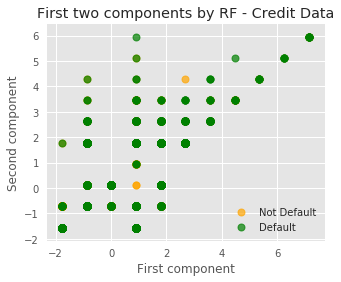

In [24]:
X_train_features_RF = X_train[features_importance.head(int(features_importance.shape[0]/2))['Feature'].tolist()]
X_test_features_RF = X_test[features_importance.head(int(features_importance.shape[0]/2))['Feature'].tolist()]

plot_dr(X_train_features_RF, y_train, 'RF - Credit Data', 'CREDIT_RF') 

## Part 3: Dimension Reduction + Clustering

### 3.1 PCA & Clustering

3.1.1 PCA & K-Means Clustering

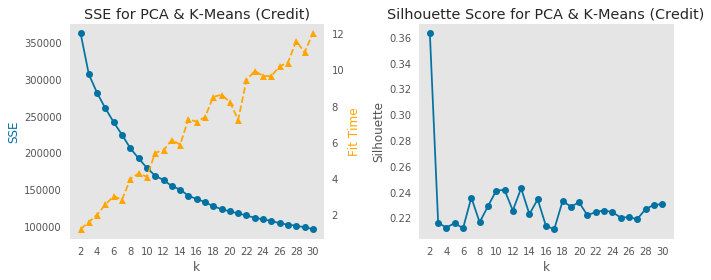

In [25]:
kmeans_exp_pca, km_models_pca = kmeans_iterate(k_range, X_train_features_PCA)

plot_kmeans_internal_valid(kmeans_exp_pca, 'PCA & K-Means', prefix='credit_pca_', dataset='(Credit)')

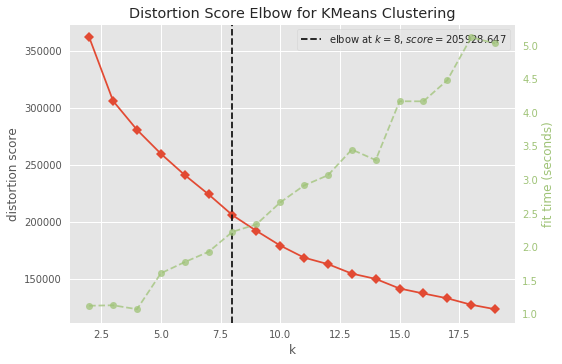

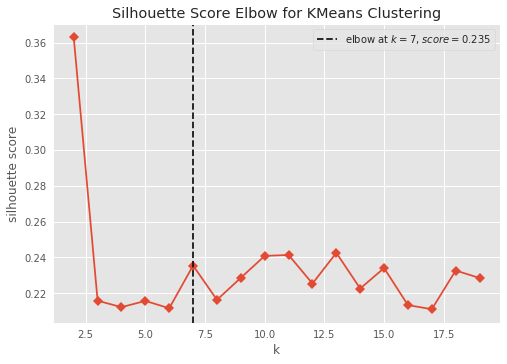

In [26]:
model = KMeans(random_state=RANDOM_SEED, n_init=20)
visualizer_sse = KElbowVisualizer(model, k=(2,20), timings=True, colors='bold')
visualizer_sse.fit(X_train_features_PCA)       
visualizer_sse.show()       
visualizer = KElbowVisualizer(model, k=(2,20),  metric='silhouette', timings=False)
visualizer.fit(X_train_features_PCA)       
visualizer.show()

For n_clusters = 3 The average silhouette_score is : 0.2158551334837819
For n_clusters = 7 The average silhouette_score is : 0.23549635481847897
For n_clusters = 10 The average silhouette_score is : 0.24089894216410154


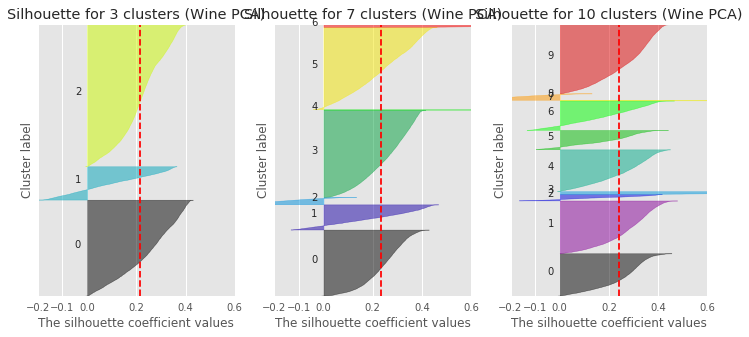

In [32]:
plot_silhouette([3, 7,10], X_train_features_PCA, 'kmeans', title='credit_pca_', dataset='Wine PCA')

In [33]:
kmeans_external_pca = plot_eval_external(km_models_pca, [2, 3, 7, 10, 11], X_train_features_PCA, y_train)
            
kmeans_external_pca

,k,homo_score,complete_score,v_score,adj_rand_index,adj_mutual_info
0,2,0.000088,0.000108,0.000097,-0.005197,0.000048
1,3,0.015006,0.008235,0.010635,-0.014230,0.010571
2,7,0.015599,0.005705,0.008355,0.001044,0.008210
3,10,0.070847,0.019630,0.030742,0.017340,0.030571
4,11,0.070847,0.019592,0.030696,0.017101,0.030502


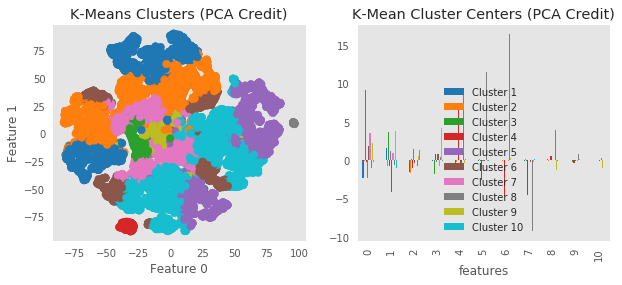

In [35]:
optimal_num_clusters = 10

optimal_kmeans_pca, optimal_kmeans_pca_centers, optimal_kmeans_pca_fit_time = optimal_kmeans_analysis(X_train_features_PCA, optimal_num_clusters, save_fig=True, title='credit_pca_',
                                                                                                      dataset='PCA Credit')

3.1.2 PCA & EM Clustering

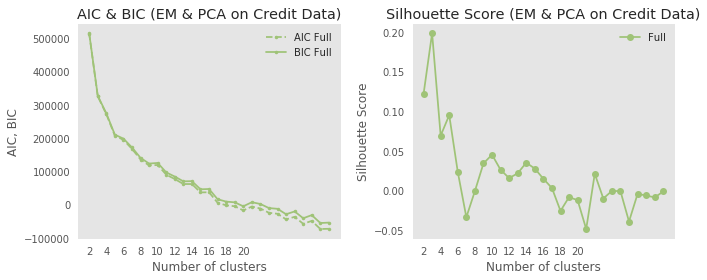

In [105]:
em_exp_full_pca, em_models_full_pca = em_iterate(k_range, X_train_features_PCA, 'full')
em_exp_all_pca = {'Full':em_exp_full_pca}
plot_em_exp(em_exp_all_pca, 'EM & PCA on Credit Data', save_fig=True, prefix='credit_pca_')


In [106]:
em_external_pca = plot_eval_external(em_models_full_pca, [2, 3, 4, 5, 6, 7, 8, 11], X_train_features_PCA, y_train)          
em_external_pca

,k,homo_score,complete_score,v_score,adj_rand_index,adj_mutual_info
0,2,0.000747,0.000576,0.000650,0.003778,0.000611
1,3,0.012450,0.011440,0.011924,-0.038916,0.011838
2,4,0.013609,0.006781,0.009052,-0.008612,0.008963
3,5,0.015629,0.006269,0.008948,-0.009539,0.008846
4,6,0.019040,0.006781,0.010000,-0.015493,0.009883
5,7,0.048405,0.014643,0.022484,-0.001396,0.022361
6,8,0.047977,0.014391,0.022141,-0.005508,0.021998
7,11,0.049302,0.012116,0.019451,0.001290,0.019277


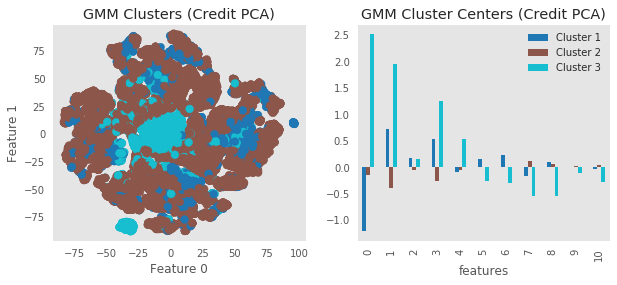

In [68]:
optimal_num_clusters_gmm = 3
optimal_gmm_pca, optimal_gmm_pca_centers, optimal_gmm_pca_fit_time = optimal_gmm_analysis(X_train_features_PCA, optimal_num_clusters_gmm, 
                                                                                                      save_fig=True, title='credit_pca_', dataset='Credit PCA')

### 3.2 ICA & Clustering

3.2.1 ICA & K-Means Clustering

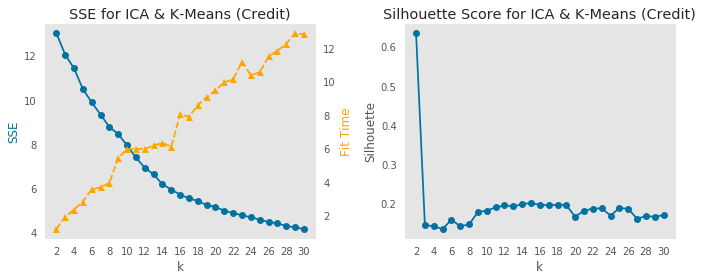

In [36]:
kmeans_exp_ica, km_models_ica = kmeans_iterate(k_range, X_train_features_ICA)

plot_kmeans_internal_valid(kmeans_exp_ica, 'ICA & K-Means', prefix='credit_ICA_', dataset='(Credit)')

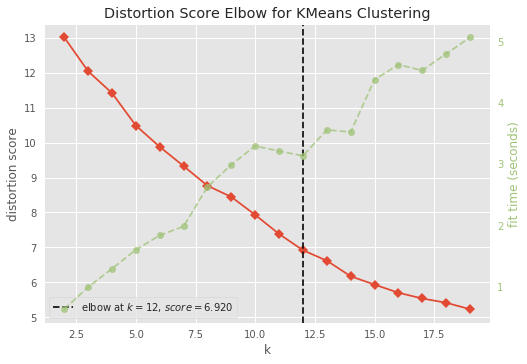

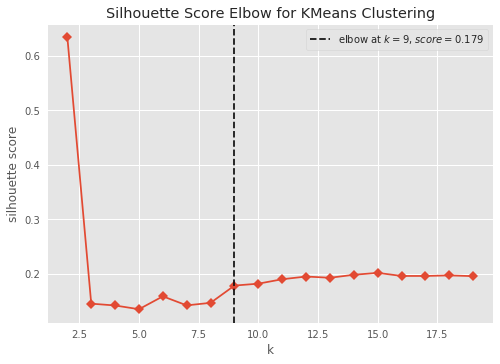

In [37]:
model = KMeans(random_state=RANDOM_SEED, n_init=20)
visualizer_sse = KElbowVisualizer(model, k=(2,20), timings=True, colors='bold')

visualizer_sse.fit(X_train_features_ICA)       
visualizer_sse.show()       


visualizer = KElbowVisualizer(model, k=(2,20),  metric='silhouette', timings=False)

visualizer.fit(X_train_features_ICA)       
visualizer.show()

For n_clusters = 3 The average silhouette_score is : 0.14533982367396373
For n_clusters = 7 The average silhouette_score is : 0.1421815924814258
For n_clusters = 9 The average silhouette_score is : 0.17852349942969553


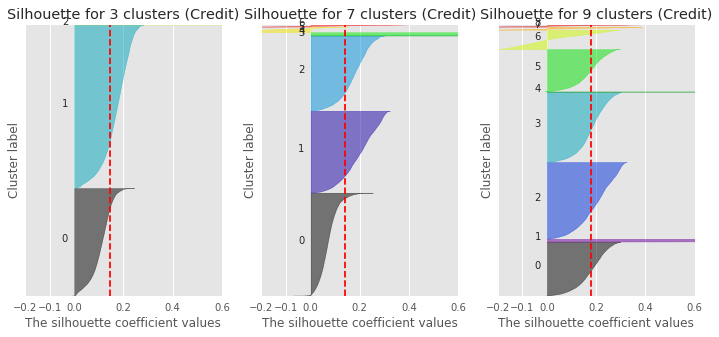

In [38]:
plot_silhouette([3,7,9], X_train_features_ICA, 'kmeans', title='credit_ica_', dataset='Credit')       

In [39]:
kmeans_external_ica = plot_eval_external(km_models_ica, [2, 3, 4, 7, 9], X_train_features_ICA, y_train)
            
kmeans_external_ica

,k,homo_score,complete_score,v_score,adj_rand_index,adj_mutual_info
0,2,0.000108,0.001003,0.000195,0.002830,0.000113
1,3,0.001769,0.001370,0.001544,0.008140,0.001465
2,4,0.002411,0.001604,0.001926,-0.004522,0.001817
3,7,0.004147,0.001737,0.002449,-0.005367,0.002289
4,9,0.003745,0.001197,0.001814,0.001350,0.001639


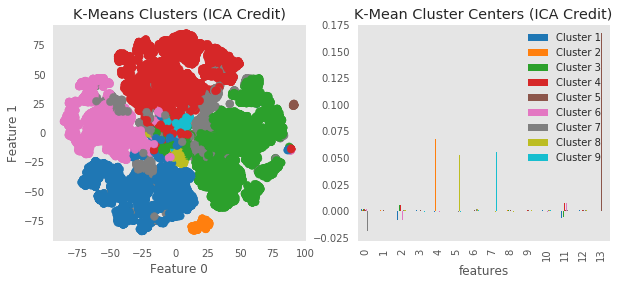

In [40]:
optimal_num_clusters = 9

optimal_kmeans_ica, optimal_kmeans_ica_centers, optimal_kmeans_ica_fit_time = optimal_kmeans_analysis(X_train_features_ICA, optimal_num_clusters, save_fig=True, title='credit_ica_', dataset='ICA Credit')

3.2.1 ICA & EM Clustering

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30


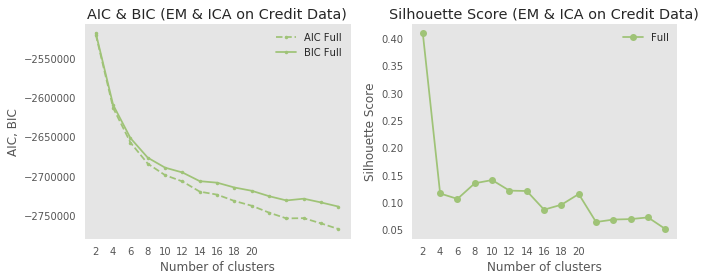

In [70]:
k_range = range(2,31,2)
em_exp_full_ica, em_models_full_ica = em_iterate(k_range, X_train_features_ICA, 'full')
em_exp_all_ica = {'Full':em_exp_full_ica}
plot_em_exp(em_exp_all_ica, 'EM & ICA on Credit Data', save_fig=True, prefix='credit_ica_')  

In [74]:
em_external_ica = plot_eval_external(em_models_full_ica, [2, 4,  6,  8, 10], X_train_features_ICA, y_train)          
em_external_ica

,k,homo_score,complete_score,v_score,adj_rand_index,adj_mutual_info
0,2,0.009393,0.012666,0.010787,-0.048696,0.010736
1,4,0.013857,0.006676,0.009011,-0.012524,0.008924
2,6,0.013579,0.004766,0.007056,-0.008007,0.006940
3,8,0.013397,0.003967,0.006122,-0.003882,0.005978
4,10,0.015667,0.004415,0.006889,-0.005548,0.006711


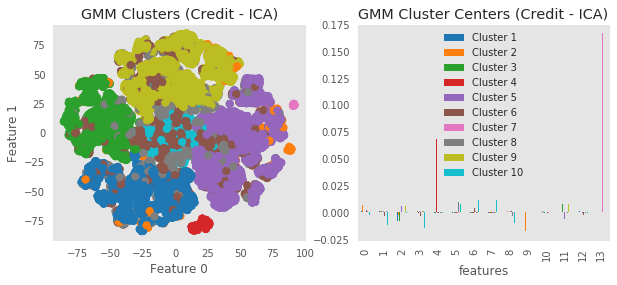

In [75]:
optimal_num_clusters_gmm = 10
optimal_gmm_ica, optimal_gmm_ica_centers, optimal_gmm_ica_fit_time = optimal_gmm_analysis(X_train_features_ICA, optimal_num_clusters_gmm, 
                                                                                                      save_fig=True, title='credit_ica_', dataset='Credit - ICA')

### 3.3 RP & Clustering

3.3.1 RP & K-Means Clustering

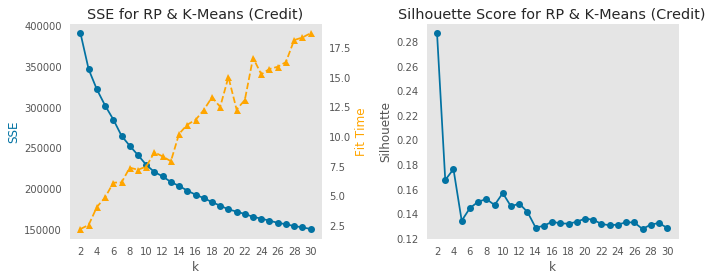

In [41]:
kmeans_exp_rp, km_models_rp = kmeans_iterate(k_range, X_train_features_RP)

plot_kmeans_internal_valid(kmeans_exp_rp, 'RP & K-Means', prefix='credit_RP_', dataset='(Credit)')

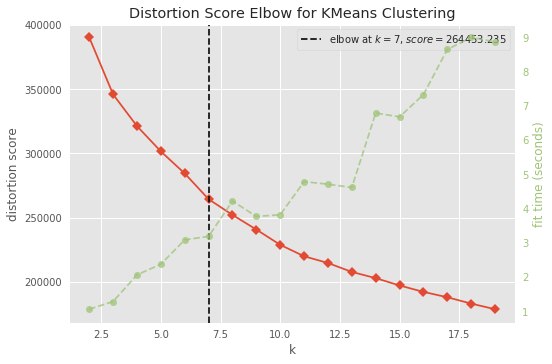

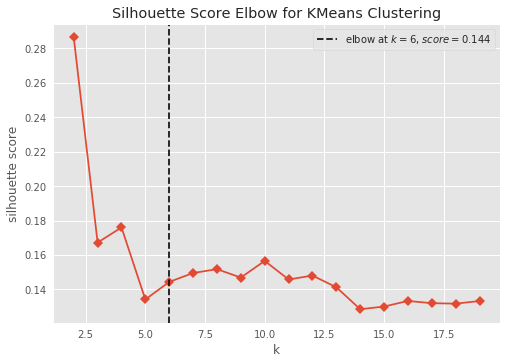

In [42]:
model = KMeans(random_state=RANDOM_SEED, n_init=20)
visualizer_sse = KElbowVisualizer(model, k=(2,20), timings=True, colors='bold')

visualizer_sse.fit(X_train_features_RP)       
visualizer_sse.show()       


visualizer = KElbowVisualizer(model, k=(2,20),  metric='silhouette', timings=False)

visualizer.fit(X_train_features_RP)       
visualizer.show()

For n_clusters = 4 The average silhouette_score is : 0.17601672777957508
For n_clusters = 6 The average silhouette_score is : 0.14437623653864112
For n_clusters = 7 The average silhouette_score is : 0.1495412121662625


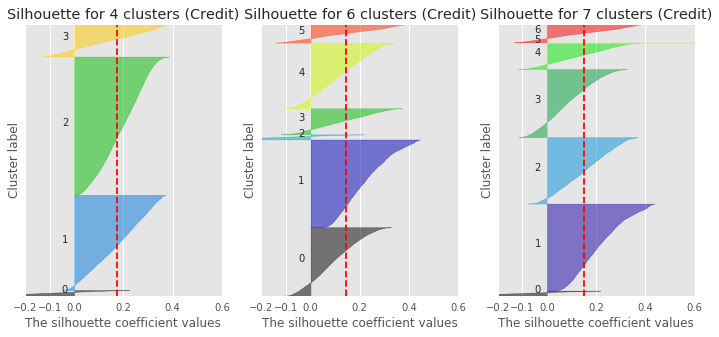

In [44]:
plot_silhouette([4,6,7], X_train_features_RP, 'kmeans', title='credit_rp_', dataset='Credit')       

In [45]:
kmeans_external_rp = plot_eval_external(km_models_rp, [2,3,4,6,7,9], X_train_features_RP, y_train)
            
kmeans_external_rp

,k,homo_score,complete_score,v_score,adj_rand_index,adj_mutual_info
0,2,0.013140,0.012267,0.012689,0.060002,0.012646
1,3,0.007944,0.004351,0.005622,-0.007379,0.005559
2,4,0.009473,0.004799,0.006371,-0.009204,0.006280
3,6,0.068481,0.023565,0.035064,0.034705,0.034953
4,7,0.069080,0.023617,0.035200,0.034428,0.035067
5,9,0.069756,0.021344,0.032686,0.026901,0.032522


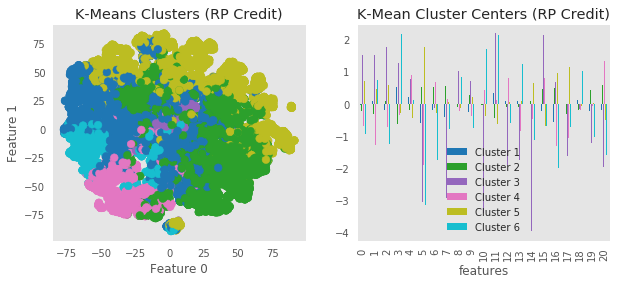

In [47]:
optimal_num_clusters = 6

optimal_kmeans_rp, optimal_kmeans_rp_centers, optimal_kmeans_rp_fit_time = optimal_kmeans_analysis(X_train_features_RP, 
                                                                                                   optimal_num_clusters, 
                                                                                                   save_fig=True, title='credit_rp_', dataset='RP Credit')

3.3.2 RP & EM Clustering

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30


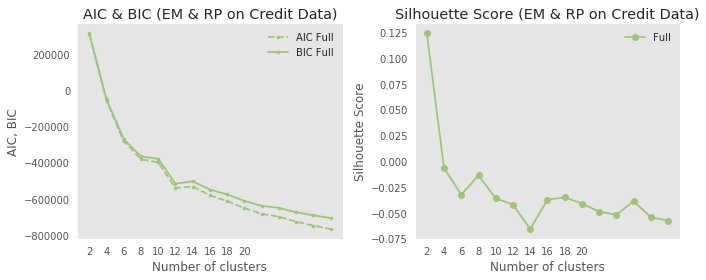

In [76]:
em_exp_full_rp, em_models_full_rp = em_iterate(k_range, X_train_features_RP, 'full')
em_exp_all_rp = {'Full':em_exp_full_rp}
plot_em_exp(em_exp_all_rp, 'EM & RP on Credit Data', save_fig=True, prefix='credit_rp_')

In [77]:
em_external_rp = plot_eval_external(em_models_full_rp, [2,4,6,8,10], X_train_features_RP, y_train)          
em_external_rp

,k,homo_score,complete_score,v_score,adj_rand_index,adj_mutual_info
0,2,0.014109,0.012036,0.012990,-0.031480,0.012949
1,4,0.027619,0.011093,0.015828,-0.004720,0.015752
2,6,0.072040,0.022405,0.034180,0.017082,0.034077
3,8,0.078621,0.022163,0.034579,0.028430,0.034444
4,10,0.092028,0.023390,0.037300,0.031746,0.037141


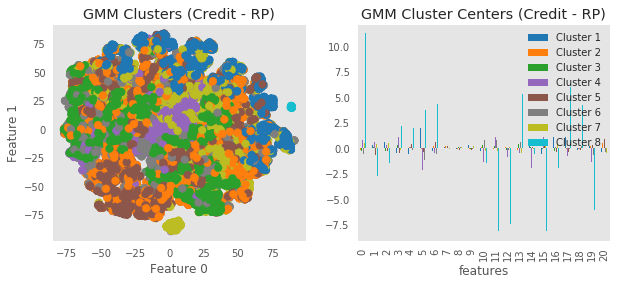

In [80]:
optimal_num_clusters_gmm = 8
optimal_gmm_rp, optimal_gmm_rp_centers, optimal_gmm_rp_fit_time = optimal_gmm_analysis(X_train_features_RP, optimal_num_clusters_gmm, 
                                                                                                      save_fig=True, title='credit_rp_', dataset='Credit - RP')

### 3.4 RF & Clustering

3.4.1 RF & K-Means Clustering

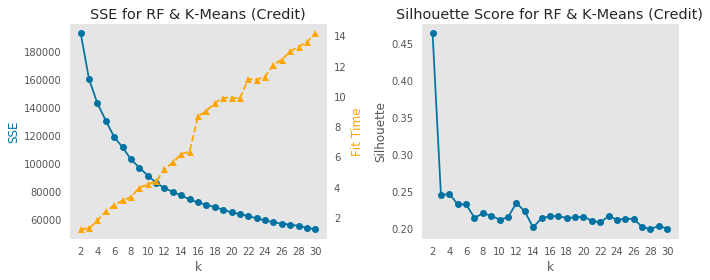

In [48]:
kmeans_exp_rf, km_models_rf = kmeans_iterate(k_range, X_train_features_RF)

plot_kmeans_internal_valid(kmeans_exp_rf, 'RF & K-Means', prefix='credit_RF_', dataset='(Credit)')

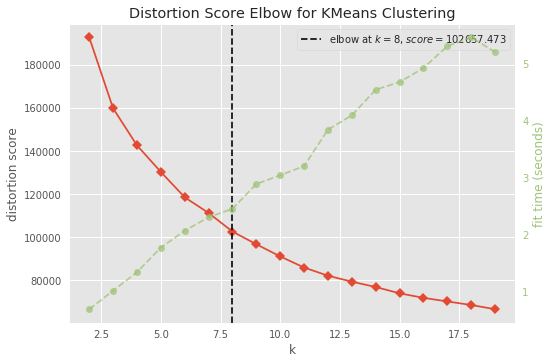

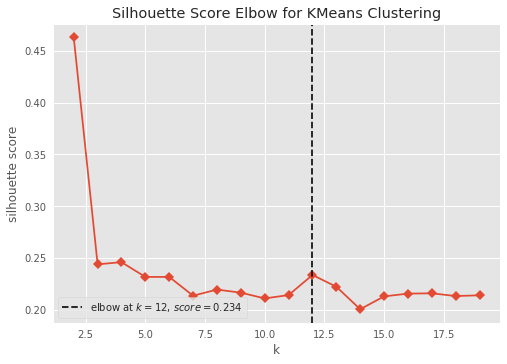

In [49]:
model = KMeans(random_state=RANDOM_SEED, n_init=20)
visualizer_sse = KElbowVisualizer(model, k=(2,20), timings=True, colors='bold')

visualizer_sse.fit(X_train_features_RF)       
visualizer_sse.show()       


visualizer = KElbowVisualizer(model, k=(2,20),  metric='silhouette', timings=False)

visualizer.fit(X_train_features_RF)       
visualizer.show()

For n_clusters = 4 The average silhouette_score is : 0.24600820585474065
For n_clusters = 6 The average silhouette_score is : 0.2317565412341025
For n_clusters = 12 The average silhouette_score is : 0.23364391436619078


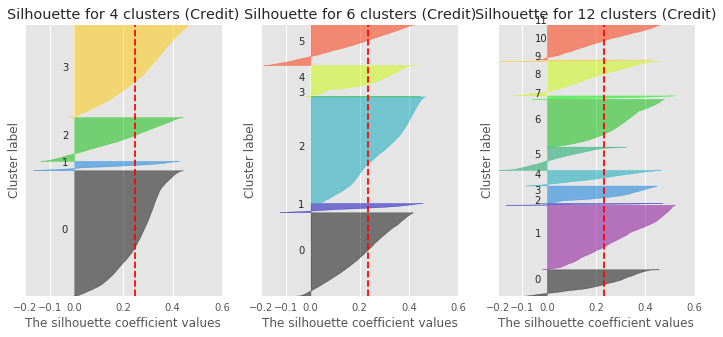

In [51]:
plot_silhouette([4,6, 12], X_train_features_RF, 'kmeans', title='credit_rf_', dataset='Credit')            

In [52]:
kmeans_external_rf = plot_eval_external(km_models_rf, [2,3,4,6, 8, 12], X_train_features_RF, y_train)
            
kmeans_external_rf

,k,homo_score,complete_score,v_score,adj_rand_index,adj_mutual_info
0,2,0.000218,0.000282,0.000245,-0.008207,0.000195
1,3,0.017487,0.009663,0.012448,-0.014511,0.012385
2,4,0.021722,0.010145,0.013830,-0.008882,0.013745
3,6,0.080173,0.030751,0.044452,0.048422,0.044328
4,8,0.083605,0.028018,0.041971,0.036248,0.041814
5,12,0.088314,0.022577,0.035961,0.018969,0.035762


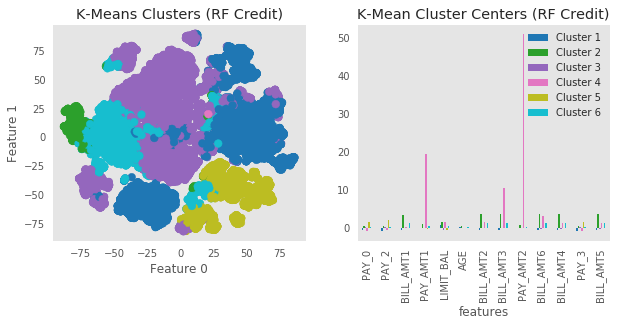

In [53]:
optimal_num_clusters = 6

optimal_kmeans_rf, optimal_kmeans_rf_centers, optimal_kmeans_rf_fit_time = optimal_kmeans_analysis(X_train_features_RF, 
                                                                                                   optimal_num_clusters, 
                                                                                                   save_fig=True, title='credit_rf_', dataset='RF Credit')

3.4.2 RF & EM Clustering

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30


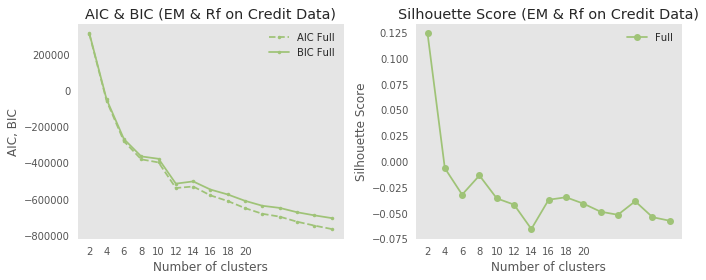

In [78]:
em_exp_full_rf, em_models_full_rf = em_iterate(k_range, X_train_features_RF, 'full')
em_exp_all_rf = {'Full':em_exp_full_rp}
plot_em_exp(em_exp_all_rf, 'EM & Rf on Credit Data', save_fig=True, prefix='credit_rf_')

In [79]:
em_external_rp = plot_eval_external(em_models_full_rf, [2,4,6,8,10], X_train_features_RF, y_train)          
em_external_rp

,k,homo_score,complete_score,v_score,adj_rand_index,adj_mutual_info
0,2,0.018706,0.015481,0.016942,-0.028344,0.016901
1,4,0.093898,0.037131,0.053218,0.060618,0.053145
2,6,0.110602,0.035392,0.053625,0.063131,0.053522
3,8,0.096083,0.026876,0.042003,0.043593,0.041871
4,10,0.104428,0.027058,0.042980,0.035730,0.042817


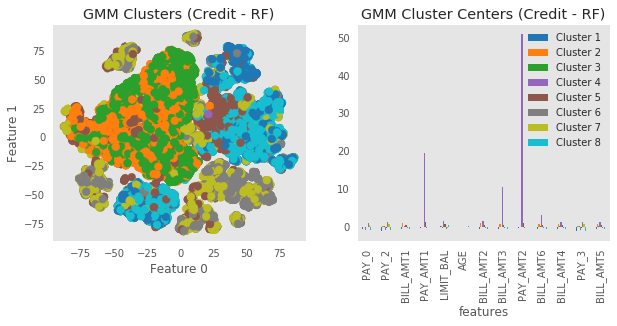

In [81]:
optimal_num_clusters_gmm = 8
optimal_gmm_rf, optimal_gmm_rf_centers, optimal_gmm_rf_fit_time = optimal_gmm_analysis(X_train_features_RF, optimal_num_clusters_gmm, 
                                                                                                      save_fig=True, title='credit_rf_', dataset='Credit - RF')

### 3.5 Comparison

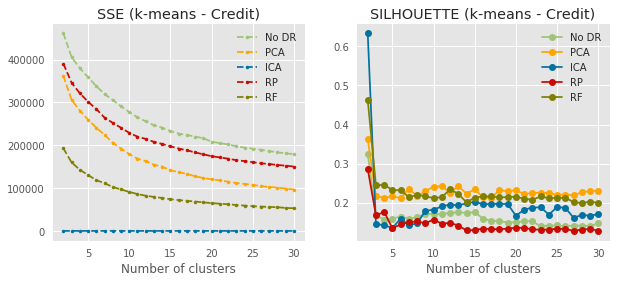

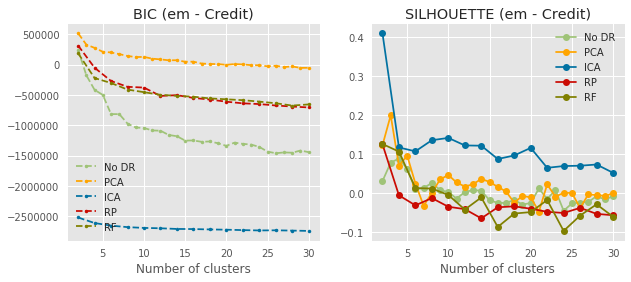

In [83]:
em_exp_full = pd.read_csv('em_exp_full.csv')

res_km = {'No DR': pd.DataFrame(kmeans_exp),
          'PCA':pd.DataFrame(kmeans_exp_pca),
          'ICA':pd.DataFrame(kmeans_exp_ica),
          'RP':pd.DataFrame(kmeans_exp_rp),
          'RF':pd.DataFrame(kmeans_exp_rf)}

res_em = {'No DR': pd.DataFrame(em_exp_full),
          'PCA':pd.DataFrame(em_exp_full_pca),
          'ICA':pd.DataFrame(em_exp_full_ica),
          'RP':pd.DataFrame(em_exp_full_rp),
          'RF':pd.DataFrame(em_exp_full_rf)}
def plot_cluster_comp(dict_res, model, dataset):
    colors = ['g','orange','b','r','olive']
    metric = 'sse' if model == 'k-means' else 'bic'
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    for i, k in enumerate(list(dict_res.keys())):
        ax[0].plot(dict_res[k]['k'], dict_res[k][metric], linestyle = '--', marker='.',  color=colors[i], label=k)
        ax[1].plot(dict_res[k]['k'], dict_res[k]['silhouette'], marker='o', color=colors[i], label=k )
    ax[0].set_xlabel('Number of clusters')
    ax[1].set_xlabel('Number of clusters')
    ax[0].legend()
    ax[1].legend()
    ax[0].set_title(metric.upper() + " ({} - {})".format(model, dataset))
    ax[1].set_title('silhouette'.upper() + " ({} - {})".format(model, dataset))
    plt.savefig(dataset+"_"+model+"comparison.png", dpi=100)
    plt.show()
plot_cluster_comp(res_km, 'k-means', dataset='Credit')   
plot_cluster_comp(res_em, 'em', dataset='Credit')   




## Part 4: Dimension Reduction + Neural Networks

In [87]:
from sklearn.neural_network import MLPClassifier

# Same Setting as Assignment 1
param_grid = {'learning_rate':['constant', 'adaptive'], 'alpha':[0.0001, 0.005]}  

mlpc = MLPClassifier(max_iter=500)

best_alpha = 0.0050
best_learning_rate = 'adaptive'
best_hls = (10,)

In [88]:
# Apply the best setttings of NN
import time             
             
def nn_train_pred(mlpc, X_train, y_train, X_test, y_test):
    start_time = time.process_time()
    mlpc.fit(X_train, y_train)
    elapse = time.process_time() - start_time
    
    performance = {}
    
    y_pred_train_label = mlpc.predict(X_train)
    y_pred_train_prob = mlpc.predict_proba(X_train)[:,1]
    y_pred_test_label = mlpc.predict(X_test)
    y_pred_test_prob = mlpc.predict_proba(X_test)[:,1]
    
    performance['auc_train'] = roc_auc_score(y_train, y_pred_train_prob)
    performance['auc_test']= roc_auc_score(y_test, y_pred_test_prob)
    performance['accuracy_train'] = accuracy_score(y_train, y_pred_train_label)
    performance['accuracy_test']= accuracy_score(y_test, y_pred_test_label)
    performance['fit_time']= elapse
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_test_prob)
    roc_curve_res  = [fpr, tpr]
    
        
    return performance, roc_curve_res


mlpc_original = MLPClassifier(max_iter=500, learning_rate=best_learning_rate, alpha=best_alpha, hidden_layer_sizes = best_hls, 
                              random_state = RANDOM_SEED)
nn_orig_perf, roc_curve_orig = nn_train_pred(mlpc, X_train, y_train, X_test, y_test)
nn_orig_perf['DR_method'] = 'No DR'
nn_orig_perf_df = pd.DataFrame(nn_orig_perf, index=[0])

nn_orig_perf_df

,auc_train,auc_test,accuracy_train,accuracy_test,fit_time,DR_method
0,0.830286,0.760843,0.836286,0.811667,40.065841,No DR


### 4.1 Tune NN using PCA results

Tune Hyperparameters using PCA transformed features (14 components)

In [ ]:
# Use function GridSearchCV 
param_grid = {'learning_rate':['constant', 'adaptive'], 'alpha':[0.0001, 0.005, 0.001],
}  

mlpc = MLPClassifier(max_iter=500, random_state = RANDOM_SEED,  hidden_layer_sizes = best_hls)
grid = GridSearchCV(estimator=mlpc, param_grid=param_grid,  cv=N_FOLDS, scoring = 'roc_auc', verbose=3)

grid.fit(X_train_features_PCA, y_train) 

# Find best model parameters
print ("Best Model Parameters:", grid.best_params_)

Using best hyperparameter settings: Best Model Parameters: {'alpha': 0.0001, 'learning_rate': 'constant'}

In [89]:
mlpc_pca = MLPClassifier(max_iter=500, learning_rate='constant', alpha=0.005, hidden_layer_sizes = best_hls, 
                              random_state = RANDOM_SEED)
nn_pca_perf, roc_curve_pca = nn_train_pred(mlpc_pca, X_train_features_PCA, y_train, X_test_features_PCA, y_test)
nn_pca_perf['DR_method'] = 'PCA'
nn_pca_perf_df = pd.DataFrame(nn_pca_perf, index=[0])
nn_pca_perf_df

,auc_train,auc_test,accuracy_train,accuracy_test,fit_time,DR_method
0,0.766424,0.757898,0.809905,0.805,4.363582,PCA


### 4.2 Run NN using ICA results


Tune Hyperparameters using ICA transformed features (14 components)

In [ ]:
mlpc = MLPClassifier(max_iter=500, random_state = RANDOM_SEED,  hidden_layer_sizes = best_hls)
grid = GridSearchCV(estimator=mlpc, param_grid=param_grid,  cv=N_FOLDS, scoring = 'roc_auc', verbose=3)

grid.fit(X_train_features_ICA, y_train) 

# Find best model parameters
print ("Best Model Parameters:", grid.best_params_)

Using best hyperparameter settings: Best Model Parameters: {'alpha': 0.0001, 'learning_rate': 'constant'}


In [90]:
mlpc_ica = MLPClassifier(max_iter=500, learning_rate='constant', alpha=0.0001, hidden_layer_sizes = best_hls, 
                              random_state = RANDOM_SEED)

nn_ica_perf, roc_curve_ica = nn_train_pred(mlpc_ica, X_train_features_ICA, y_train, X_test_features_ICA, y_test)


nn_ica_perf['DR_method'] = 'ICA'
nn_ica_perf_df = pd.DataFrame(nn_ica_perf, index=[0])
nn_ica_perf_df

,auc_train,auc_test,accuracy_train,accuracy_test,fit_time,DR_method
0,0.715677,0.70819,0.804571,0.801333,5.097091,ICA


### 4.3 Run NN using RP results

Tune Hyperparameters using RP transformed features (24 components)

In [ ]:
mlpc = MLPClassifier(max_iter=500, random_state = RANDOM_SEED,  hidden_layer_sizes = best_hls)
grid = GridSearchCV(estimator=mlpc, param_grid=param_grid,  cv=N_FOLDS, scoring = 'roc_auc', verbose=3)

grid.fit(X_train_features_RP, y_train) 

# Find best model parameters
print ("Best Model Parameters:", grid.best_params_)

Using best hyperparameter settings: Best Model Parameters: {'alpha': 0.001, 'learning_rate': 'constant'}

In [91]:
mlpc_rp = MLPClassifier(max_iter=500, learning_rate='constant', alpha=0.0001, hidden_layer_sizes = best_hls, 
                              random_state = RANDOM_SEED)

nn_rp_perf, roc_curve_rp = nn_train_pred(mlpc_rp, X_train_features_RP, y_train, X_test_features_RP, y_test)


nn_rp_perf['DR_method'] = 'RP'
nn_rp_perf_df = pd.DataFrame(nn_rp_perf, index=[0])
nn_rp_perf_df

,auc_train,auc_test,accuracy_train,accuracy_test,fit_time,DR_method
0,0.779907,0.765231,0.821429,0.818222,5.457504,RP


### 4.4 Run NN using RF results

Tune Hyperparameters using RF transformed features (14 components)

In [ ]:
mlpc = MLPClassifier(max_iter=500, random_state = RANDOM_SEED,  hidden_layer_sizes = best_hls)
grid = GridSearchCV(estimator=mlpc, param_grid=param_grid,  cv=N_FOLDS, scoring = 'roc_auc', verbose=3)

grid.fit(X_train_features_RF, y_train) 

# Find best model parameters
print ("Best Model Parameters:", grid.best_params_)

Using best hyperparameter settings: Best Model Parameters: {'alpha': 0.0001, 'learning_rate': 'constant'}

In [92]:
mlpc_rf = MLPClassifier(max_iter=500, learning_rate='constant', alpha=0.005, hidden_layer_sizes = best_hls, 
                              random_state = RANDOM_SEED)

nn_rf_perf, roc_curve_rf = nn_train_pred(mlpc_rf, X_train_features_RF, y_train, X_test_features_RF, y_test)


nn_rf_perf['DR_method'] = 'RF'
nn_rf_perf_df = pd.DataFrame(nn_rf_perf, index=[0])
nn_rf_perf_df

,auc_train,auc_test,accuracy_train,accuracy_test,fit_time,DR_method
0,0.779042,0.761177,0.819857,0.816778,5.048366,RF


In [93]:
from sklearn.model_selection import learning_curve

def cal_learning_curve(estimator, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    The learning curve code is modified based on 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    """


    train_sizes, train_auc, test_auc, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True, random_state=RANDOM_SEED, 
                       scoring='roc_auc')
    train_auc_mean = np.mean(train_auc, axis=1)
    test_auc_mean = np.mean(test_auc, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    train_sizes_normalized = train_sizes/max(train_sizes)
    print (train_sizes_normalized)
    print (train_sizes)
    
    return train_sizes_normalized, test_auc_mean, fit_times_mean

train_sizes_normalized_nodr, test_auc_mean_nodr, fit_times_mean_nodr = cal_learning_curve(mlpc_original, X_train, y_train,cv=N_FOLDS)

train_sizes_normalized_pca, test_auc_mean_pca, fit_times_mean_pca = cal_learning_curve(mlpc_pca, X_train_features_PCA, y_train,cv=N_FOLDS)

train_sizes_normalized_ica, test_auc_mean_ica, fit_times_mean_ica = cal_learning_curve(mlpc_ica, X_train_features_ICA, y_train,cv=N_FOLDS)

train_sizes_normalized_rp, test_auc_mean_rp, fit_times_mean_rp = cal_learning_curve(mlpc_rp, X_train_features_RP, y_train,cv=N_FOLDS)

train_sizes_normalized_rf, test_auc_mean_rf, fit_times_mean_rf = cal_learning_curve(mlpc_rf, X_train_features_RF, y_train,cv=N_FOLDS)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum

[0.1   0.325 0.55  0.775 1.   ]
[ 1680  5460  9240 13020 16800]
[0.1   0.325 0.55  0.775 1.   ]
[ 1680  5460  9240 13020 16800]
[0.1   0.325 0.55  0.775 1.   ]
[ 1680  5460  9240 13020 16800]
[0.1   0.325 0.55  0.775 1.   ]
[ 1680  5460  9240 13020 16800]
[0.1   0.325 0.55  0.775 1.   ]
[ 1680  5460  9240 13020 16800]


### 4.5 Comparison

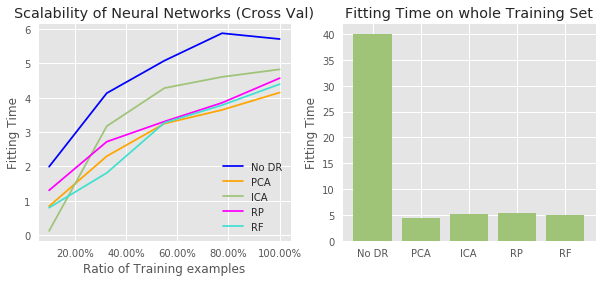

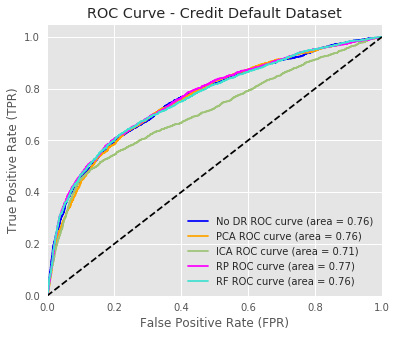

In [94]:
comparison = pd.concat([nn_orig_perf_df, nn_pca_perf_df, nn_ica_perf_df, nn_rp_perf_df, nn_rf_perf_df])
colors = ['blue','orange','g','magenta','turquoise']
fit_time_set = [fit_times_mean_nodr,fit_times_mean_pca,fit_times_mean_ica,fit_times_mean_rp, fit_times_mean_rf]
names_ = ['No DR','PCA','ICA','RP','RF']

fig, ax = plt.subplots(1,2, figsize=(10,4))
for i in range(5):
    ax[0].plot(train_sizes_normalized_nodr, fit_time_set[i], colors[i], label=names_[i])
ax[0].set_xlabel("Ratio of Training examples")
ax[0].set_ylabel("Fitting Time")
ax[0].set_title("Scalability of Neural Networks (Cross Val)")
xticks = ax[0].get_xticks()
ax[0].set_xticklabels(['{:,.2%}'.format(x) for x in xticks])
ax[0].legend()
ax[1].bar(comparison['DR_method'], comparison['fit_time'], color='g')
ax[1].set_title('Fitting Time on whole Training Set')
ax[1].set_ylabel("Fitting Time")
plt.savefig('Credit_Fitting_Time.png', dpi=100)
plt.show()


roc_curve_dict = {'No DR': roc_curve_orig, 'PCA': roc_curve_pca, 'ICA': roc_curve_ica,
                 'RP': roc_curve_rp, 'RF':roc_curve_rf}

fig, ax = plt.subplots(1,1, figsize=(6,5))
for i, name_ in enumerate(list(roc_curve_dict.keys())):
    ax.plot(roc_curve_dict[name_][0],roc_curve_dict[name_][1], 
            color=colors[i], label='%s ROC curve (area = %0.2f)' % (name_, 
                                                                    comparison[comparison['DR_method'] == name_]['auc_test']))

ax.plot([0, 1], [0, 1], color='black', linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Credit Default Dataset')
plt.legend()
plt.savefig("Credit_ROC_all.png",dpi=100)
plt.show()

## Part 5: Clustering + Neural Networks

### 5.1 Run NN using K-Means Clustering results as new features

In [95]:
# Add clustering labels to features
labels_train = optimal_kmeans_orig.predict(X_train)
labels_test = optimal_kmeans_orig.predict(X_test)
X_train_set = {'PCA':X_train_features_PCA,'ICA':X_train_features_ICA,'RP':X_train_features_RP, 'RF':X_train_features_RF}

X_test_set = {'PCA':X_test_features_PCA,'ICA':X_test_features_ICA,'RP':X_test_features_RP, 'RF':X_test_features_RF}
X_train_set_km = {}
X_test_set_km = {}
for key in X_train_set:
    X_train_set_km[key]=X_train_set[key].copy()
    X_test_set_km[key]=X_test_set[key].copy()
    X_train_set_km[key]['km_cluster'] = labels_train
    X_test_set_km[key]['km_cluster'] = labels_test
    X_train_set_km[key] = pd.get_dummies(X_train_set_km[key], columns=['km_cluster'])
    X_test_set_km[key] = pd.get_dummies(X_test_set_km[key], columns=['km_cluster'])

    
    # Use function GridSearchCV 
    param_grid = {'learning_rate':['constant', 'adaptive'], 'alpha':[0.0001, 0.005, 0.001],
    }  

    mlpc = MLPClassifier(max_iter=500, random_state = RANDOM_SEED,  hidden_layer_sizes = best_hls)
    grid = GridSearchCV(estimator=mlpc, param_grid=param_grid,  cv=N_FOLDS, scoring = 'roc_auc', verbose=3)

    grid.fit(X_train_set_km[key], y_train) 

    # Find best model parameters
    print (key)
    print ("Best Model Parameters:", grid.best_params_)
    

In [96]:
mlpc_km_pca = MLPClassifier(max_iter=500, learning_rate='constant', alpha=0.0001, hidden_layer_sizes = best_hls, 
                              random_state = RANDOM_SEED)

nn_km_pca_perf, roc_curve_km_pca = nn_train_pred(mlpc_km_pca, X_train_set_km['PCA'], y_train,
                                                 X_test_set_km['PCA'], y_test)

nn_km_pca_perf['Cluster_method'] = 'KM'
nn_km_pca_perf['DR_method'] = 'PCA'
nn_km_pca_perf_df = pd.DataFrame(nn_km_pca_perf, index=[0])

mlpc_km_ica = MLPClassifier(max_iter=500, learning_rate='constant', alpha=0.0001, hidden_layer_sizes = best_hls, 
                              random_state = RANDOM_SEED)

nn_km_ica_perf, roc_curve_km_ica = nn_train_pred(mlpc_km_ica, X_train_set_km['ICA'], y_train,
                                                 X_test_set_km['ICA'], y_test)

nn_km_ica_perf['Cluster_method'] = 'KM'
nn_km_ica_perf['DR_method'] = 'ICA'
nn_km_ica_perf_df = pd.DataFrame(nn_km_ica_perf, index=[0])

mlpc_km_rp = MLPClassifier(max_iter=500, learning_rate='constant', alpha=0.001, hidden_layer_sizes = best_hls, 
                              random_state = RANDOM_SEED)

nn_km_rp_perf, roc_curve_km_rp = nn_train_pred(mlpc_km_rp, X_train_set_km['RP'], y_train,
                                                 X_test_set_km['RP'], y_test)

nn_km_rp_perf['Cluster_method'] = 'KM'
nn_km_rp_perf['DR_method'] = 'RP'
nn_km_rp_perf_df = pd.DataFrame(nn_km_rp_perf, index=[0])

mlpc_km_rf = MLPClassifier(max_iter=500, learning_rate='constant', alpha=0.001, hidden_layer_sizes = best_hls, 
                              random_state = RANDOM_SEED)

nn_km_rf_perf, roc_curve_km_rf = nn_train_pred(mlpc_km_rf, X_train_set_km['RF'], y_train,
                                                 X_test_set_km['RF'], y_test)

nn_km_rf_perf['Cluster_method'] = 'KM'
nn_km_rf_perf['DR_method'] = 'RF'
nn_km_rf_perf_df = pd.DataFrame(nn_km_rf_perf, index=[0])




### 5.2 Run NN using EM Clustering results as new features

In [99]:
# Add clustering labels to features
labels_train = optimal_gmm_orig.predict(X_train)
labels_test = optimal_gmm_orig.predict(X_test)

X_train_set_em = {}
X_test_set_em = {}
for key in X_train_set:
    X_train_set_em[key]=X_train_set[key].copy()
    X_test_set_em[key]=X_test_set[key].copy()
    X_train_set_em[key]['em_cluster'] = labels_train
    X_test_set_em[key]['em_cluster'] = labels_test
    X_train_set_em[key] = pd.get_dummies(X_train_set_em[key], columns=['em_cluster'])
    X_test_set_em[key] = pd.get_dummies(X_test_set_em[key], columns=['em_cluster'])

    
    # Use function GridSearchCV 
    param_grid = {'learning_rate':['constant', 'adaptive'], 'alpha':[0.0001, 0.005, 0.001],
    }  

    mlpc = MLPClassifier(max_iter=500, random_state = RANDOM_SEED,  hidden_layer_sizes = best_hls)
    grid = GridSearchCV(estimator=mlpc, param_grid=param_grid,  cv=N_FOLDS, scoring = 'roc_auc', verbose=3)

    grid.fit(X_train_set_km[key], y_train) 

    # Find best model parameters
    print (key)
    print ("Best Model Parameters:", grid.best_params_)
    

In [100]:
mlpc_em_pca = MLPClassifier(max_iter=500, learning_rate='constant', alpha=0.0001, hidden_layer_sizes = best_hls, 
                              random_state = RANDOM_SEED)

nn_em_pca_perf, roc_curve_em_pca = nn_train_pred(mlpc_em_pca, X_train_set_em['PCA'], y_train,
                                                 X_test_set_em['PCA'], y_test)

nn_em_pca_perf['Cluster_method'] = 'EM'
nn_em_pca_perf['DR_method'] = 'PCA'
nn_em_pca_perf_df = pd.DataFrame(nn_em_pca_perf, index=[0])

mlpc_em_ica = MLPClassifier(max_iter=500, learning_rate='constant', alpha=0.001, hidden_layer_sizes = best_hls, 
                              random_state = RANDOM_SEED)

nn_em_ica_perf, roc_curve_em_ica = nn_train_pred(mlpc_em_ica, X_train_set_em['ICA'], y_train,
                                                 X_test_set_em['ICA'], y_test)

nn_em_ica_perf['Cluster_method'] = 'EM'
nn_em_ica_perf['DR_method'] = 'ICA'
nn_em_ica_perf_df = pd.DataFrame(nn_em_ica_perf, index=[0])

mlpc_em_rp = MLPClassifier(max_iter=500, learning_rate='constant', alpha=0.001, hidden_layer_sizes = best_hls, 
                              random_state = RANDOM_SEED)

nn_em_rp_perf, roc_curve_em_rp = nn_train_pred(mlpc_em_rp, X_train_set_em['RP'], y_train,
                                                 X_test_set_em['RP'], y_test)

nn_em_rp_perf['Cluster_method'] = 'KEMM'
nn_em_rp_perf['DR_method'] = 'RP'
nn_em_rp_perf_df = pd.DataFrame(nn_em_rp_perf, index=[0])

mlpc_em_rf = MLPClassifier(max_iter=500, learning_rate='constant', alpha=0.001, hidden_layer_sizes = best_hls, 
                              random_state = RANDOM_SEED)

nn_em_rf_perf, roc_curve_em_rf = nn_train_pred(mlpc_em_rf, X_train_set_em['RF'], y_train,
                                                 X_test_set_em['RF'], y_test)

nn_em_rf_perf['Cluster_method'] = 'EM'
nn_em_rf_perf['DR_method'] = 'RF'
nn_em_rf_perf_df = pd.DataFrame(nn_em_rf_perf, index=[0])




### 5.3 Comparison

   auc_train  auc_test  accuracy_train  accuracy_test   fit_time DR_method  \
0   0.830286  0.760843        0.836286       0.811667  40.065841     No DR   
0   0.767959  0.757252        0.811190       0.801222   4.712353       PCA   
0   0.747169  0.739241        0.808952       0.802667   9.281292       ICA   
0   0.784247  0.766735        0.821333       0.817556  15.111579        RP   
0   0.782037  0.766639        0.822476       0.815889   6.409676        RF   
0   0.771219  0.763011        0.810524       0.805333   5.859844       PCA   
0   0.740077  0.733456        0.805143       0.804222   5.908930       ICA   
0   0.785796  0.769416        0.822095       0.817222  12.344242        RP   
0   0.781871  0.765513        0.821476       0.818667   4.557810        RF   

  Cluster_method          method  
0       Original  Original No DR  
0             KM          KM PCA  
0             KM          KM ICA  
0             KM           KM RP  
0             KM           KM RF  
0        

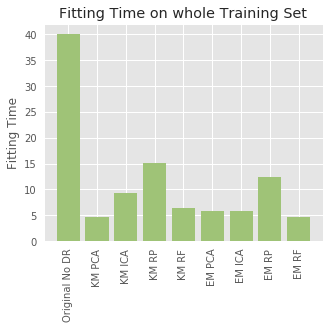

In [102]:
nn_orig_perf_df_cluster = nn_orig_perf_df.copy()
nn_orig_perf_df_cluster['Cluster_method']='Original'

comparison = pd.concat([nn_orig_perf_df_cluster,nn_km_pca_perf_df,nn_km_ica_perf_df,nn_km_rp_perf_df,nn_km_rf_perf_df,
                     nn_em_pca_perf_df,nn_em_ica_perf_df,nn_em_rp_perf_df,nn_em_rf_perf_df])
comparison['method'] = comparison['Cluster_method'] +' '+ comparison['DR_method'] 
comparison.loc[comparison.method=='KEMM RP', 'method'] = 'EM RP'
print (comparison)
colors = ['blue','orange','g','magenta','gray','turquoise', 'navy','olive','black']



fig, ax = plt.subplots(1,1, figsize=(5,4))
ax.bar(comparison['method'], comparison['fit_time'], color='g')
ax.set_title('Fitting Time on whole Training Set')
ax.set_ylabel("Fitting Time")
ax.set_xticklabels(comparison['method'],rotation=90)
plt.savefig('Credit_cluster_Fitting_Time.png', dpi=100,bbox_inches = 'tight')
plt.show()




Original No DR
KM PCA
KM ICA
KM RP
KM RF
EM PCA
EM ICA
EM RP
EM RF


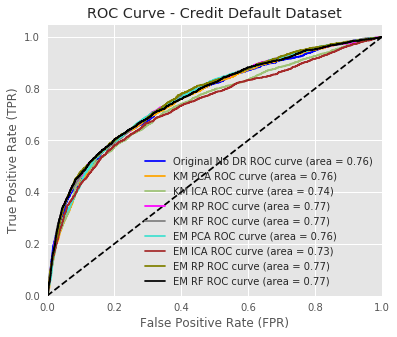

In [103]:
colors = ['blue','orange','g','magenta','gray','turquoise', 'brown','olive','black']


roc_curve_dict = {'Original No DR': roc_curve_orig, 
                  'KM PCA': roc_curve_km_pca, 'KM ICA': roc_curve_km_ica, 'KM RP': roc_curve_km_rp, 'KM RF': roc_curve_km_rf, 
                  'EM PCA': roc_curve_em_pca, 'EM ICA': roc_curve_em_ica, 'EM RP': roc_curve_em_rp, 'EM RF': roc_curve_em_rf}

fig, ax = plt.subplots(1,1, figsize=(6,5))
for i, name_ in enumerate(list(roc_curve_dict.keys())):
    print (name_)
    ax.plot(roc_curve_dict[name_][0],roc_curve_dict[name_][1], 
            color=colors[i], label='%s ROC curve (area = %0.2f)' % (name_, 
                                                                    comparison[comparison['method'] == name_]['auc_test']))

ax.plot([0, 1], [0, 1], color='black', linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Credit Default Dataset')
plt.legend()
plt.savefig("Credit_Cluster_ROC_all.png",dpi=100)
plt.show()

### =====END=====#